In [570]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from tqdm.notebook import tqdm
from tqdm import tqdm
import seaborn as sns

In [571]:
'''
!pip install cellbell
import cellbell

def play_sound(self, etype, value, tb, tb_offset=None):
    %ding
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    print('ding worked!')'''

"\n!pip install cellbell\nimport cellbell\n\ndef play_sound(self, etype, value, tb, tb_offset=None):\n    %ding\n    self.showtraceback((etype, value, tb), tb_offset=tb_offset)\n    print('ding worked!')"

In [572]:
'''
get_ipython().set_custom_exc((Exception,), play_sound)'''

'\nget_ipython().set_custom_exc((Exception,), play_sound)'

# Мысль 1. Общая структура и распределение домохозяйств по численности.

Генерирование конкретной структуры графа, например, Erdos-Reniy, Uniform, small-world кажется весьма неправдоподобной предпосылкой, кластеризация устроена по-другому. Мы отлично знаем всех людей, с которыми нас можно объединить в домохозяйство (даже если это только мы сами). Более того, это можно сказать про любого члена домохозяйства. Наша связь с другими ячейками  несколько менее тесна. С точки зрения теории графов, такая ситуация может быть описана с помощью высокой локальной плотности в графе и низкой общей плотностью.

Устроим генерацию в соответствии с этой логикой: сначала создадим популяцию с сохранением половозрастной структуры для московской аггломерации 2010-2011 годов. Затем, с помощью случайного сэмплинга воссоздадим домохозяйства, соблюдая распределение по численности членов. Поледние будут представлять из себя полные графы, т.е. все вершины внутри домохозяйства будут попарно связаны. Затем наведем между домохозйствами связи второго типа (вопрос общей плотности графа по-прежнему остается открытым даже во frontier-литературе). Понятно, что если взять 500 случайных домохозяйств в Московской аггломерации, весьма маловероятно, что среди найдутся хотя бы два связанных. Мы будем предполагать, что рассматривамые домохозяйства находятся в некотором случайном, но едином, географическом локусе. От этой предпосылки можно отказаться, если производить полную имитацию, я ограничен вычислительными мощностями.

При дальнейшей работе с контролем распределений мы сразу будем работать с наименьшим "дроблением" графа на элементы, а именно, с конкретными людьми, а не с домохозяйствами.

## Основа генерации

Возьмем некоторой достаточно приличное натуральное число людей, с которыми будет производиться вся дальнейшая работа, например 5000.

Каждого человека для дальнейшего удобства снабдим person_id - уникальным численным идентификатором.

Всю информацию будем хранить в формате словаря, где по ключу person id будут доступны значения всех аттрибутов человека, значимые для модели. Сами аттрибуты также будут храниться в форме словаря (да, получается, что мы имеем дело со словарем словарей).

In [573]:
people_dictionary = {}

for person_id in range(5000):
    people_dictionary[person_id] = {}
    
print('Длина текущего словаря: {}'.format(len(people_dictionary)))
print('Что хранится в каждом конкретном словаре (пока что ничего): {}'.format(people_dictionary[0]))

Длина текущего словаря: 5000
Что хранится в каждом конкретном словаре (пока что ничего): {}


## Половая структура

С этой частью все достаточно просто, будем использовать следующий алгоритм сэмплирования:

- возьмем соотношение численности мужского и женского населения в соответствующий период в московской аггломерации, пусть для простоты изложения это будет 1:1.

- прямым перебором пройдемся по всем людям и каждый раз будем генерировать равномерно распределенную на отрезке $[0,1]$ случайную величину.

- если реализация случайной величины окажется меньше $frac{1}{2}$, присвоим человеку мужской пол, в противном случае - женский. 

- свойства равномерного распределения гарантируют нам соблюдение пропорции в смысле почти наверное.

In [574]:
'''
Выбираем порог, начиная с которого мы разделяем пол. Данные с https://mosstat.gks.ru/folder/64634 для 2011 года.

'''
m = 5321.7
f = 6219.4
threshold = m/(m + f)
print('Порог реализации, слева - мужчины: {}'.format(round(threshold,3)))

Порог реализации, слева - мужчины: 0.461


In [575]:
random.seed(69)

for ids in tqdm(range(len(people_dictionary))):
    generated = random.uniform(0,1)
    if generated < threshold:
        people_dictionary[ids]['Пол'] = 1
    else:
        people_dictionary[ids]['Пол'] = 0

100%|██████████| 5000/5000 [00:00<00:00, 626782.63it/s]


In [576]:
'''
Проверим, что все сработало, вычислив реализовавшуюся долю мужчин в выборке
'''

counter = 0
for i in range(len(people_dictionary)):
    counter += people_dictionary[i]['Пол']

print(counter/len(people_dictionary))

0.4612


In [577]:
num_males = int(0.4612*len(people_dictionary))
num_females = int((1- 0.4612)*len(people_dictionary)) + 1
print('Число мужчин в выборке: {}'.format(num_males))
print('Число женщин в выборке: {}'.format(num_females))

Число мужчин в выборке: 2306
Число женщин в выборке: 2694


## Возрастная структура.

Достанем из расстата распределения мужского и женского населения по возрастам, а затем, используя алгоритм A&R воссоздадим это распределение на нашей имитационной популяции.

In [578]:
''' Данные с http://www.demoscope.ru/weekly/ssp/rus_reg_pop_y.php?year=2011&region=12 '''
''' Для МО оттуда же'''

#print('Верхушка для МСК:\n')

data_msc = pd.read_excel('МСК.xlsx',ecoding = 'utf8')
data_msc = data_msc[['Unnamed: 1','Unnamed: 6','Unnamed: 7']][3:104]
data_msc.columns = ['Возрастная группа','мужчины','женщины']
data_msc = data_msc.reset_index()
del data_msc['index']

#print(' \n Верхушка для МО: \n')

data_mo = pd.read_excel('МО.xlsx',ecoding = 'utf8')
data_mo = data_mo[['Unnamed: 1','Unnamed: 6','Unnamed: 7']][:101]
data_mo.columns = ['Возрастная группа','мужчины','женщины']


def c(column):
    return column.apply(lambda x: int(x))

data_all = pd.DataFrame()
data_all['Возраст'] = data_msc['Возрастная группа']
data_all['Мужчины'] = c(data_msc['мужчины']) + c(data_mo['мужчины'])
data_all['Женщины'] = c(data_msc['женщины']) + c(data_mo['женщины'])

data = data_all
data.head()

,Возраст,Мужчины,Женщины
0,0,85511,80551
1,1,89564,84944
2,2,88646,84869
3,3,84763,80338
4,4,81535,78711


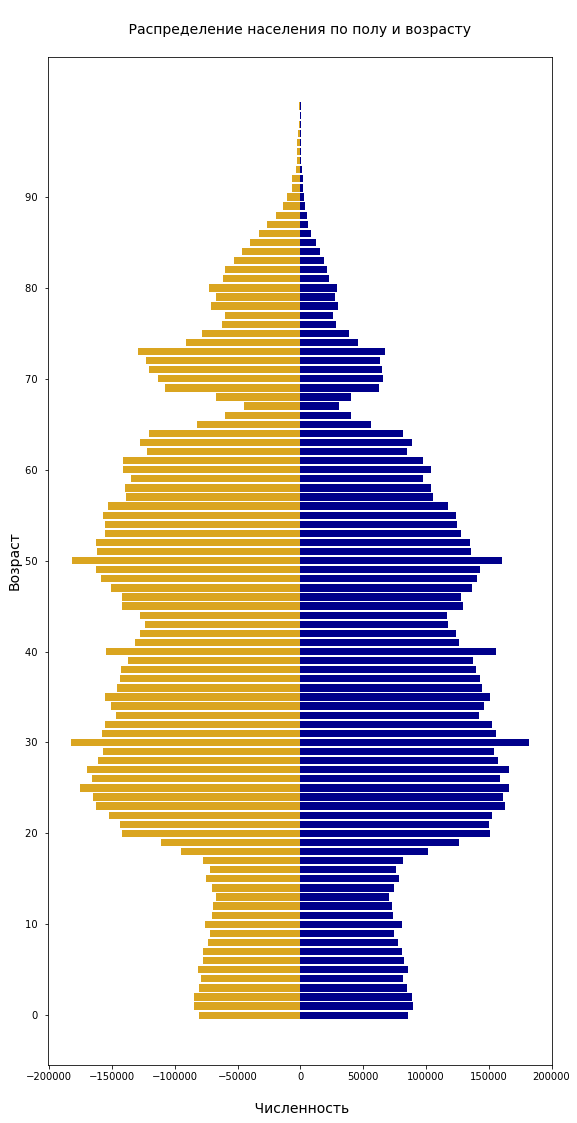

In [579]:
fig = plt.figure(figsize = (7,14))
ax = fig.add_axes([0, 0, 1, 1])
plt.barh(data['Возраст'], data['Мужчины'],color = 'darkblue')
plt.barh(data['Возраст'], -data['Женщины'],color = 'goldenrod')
plt.yticks([0,10,20,30,40,50,60,70,80,90])
ax.set_xlabel('\n Численность',fontsize = 14)
ax.set_ylabel('Возраст',fontsize = 14)
ax.set_title('\n Распределение населения по полу и возрасту \n', fontsize = 14);
plt.show()


### Работа с распределениями

Необходимо превратить возрастные структуры в плотности некоторой случайной величины, а затем взять выборки, соответствующие численностям популяций обоих полов из соответствующего распределения.

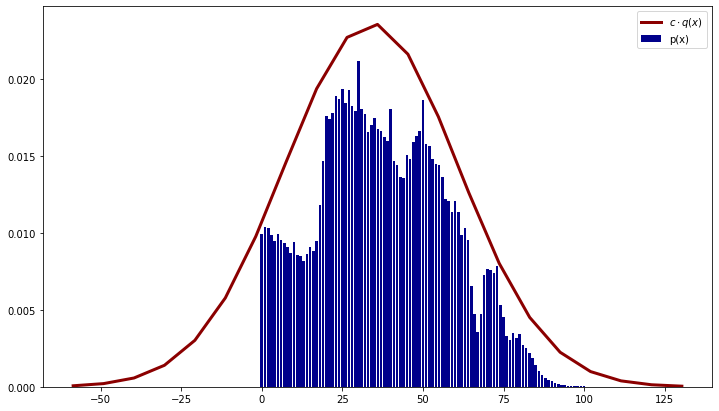

In [580]:
density_men = np.array(data['Мужчины'])/(np.array(data['Мужчины']).sum())
plt.figure(figsize = (12,7))
plt.bar(range(len(density_men)),density_men,color = 'darkblue',label = 'p(x)')

mu, sigma = 34, 27
s = np.random.normal(mu, sigma, 1000)

# Create the bins and histogram
count, bins, ignored = plt.hist(s, 20, density=True,alpha = 0)

# Plot the distribution curve
plt.plot(bins, 1.6/(sigma * np.sqrt(2 * np.pi)) *
    np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='darkred',label = '$c\cdot q(x)$')
plt.legend()
plt.savefig('Пример покрытия.png')
plt.show()


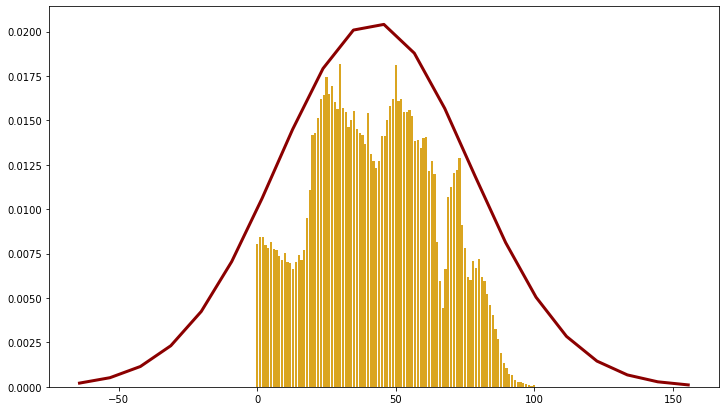

In [581]:
density_women = np.array(data['Женщины'])/(np.array(data['Женщины']).sum())
plt.figure(figsize = (12,7))
plt.bar(range(len(density_men)),density_women,color = 'goldenrod')

mu, sigma = 42, 35
s = np.random.normal(mu, sigma, 1000)

# Create the bins and histogram
count, bins, ignored = plt.hist(s, 20, density=True,alpha = 0)

# Plot the distribution curve
plt.plot(bins, 1.8/(sigma * np.sqrt(2 * np.pi)) *
    np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=3, color='darkred')
plt.show()

In [582]:
'''
Реализуем алгоритм A&R. В обоих случаях покрываем нормальным распределением, параметры с-мю-сигма дл мужчин и для женщин - 1.6,34,27, для женщин - 1.8,42,35

Теперь сэмплируем из нормального, смотрим значение в точке, если оно превосходит значение нашей плотности в этой точке, отвергаем, в противном случае принимаем и добавляем в выборку
'''

def sample_int_norm(mu, sigma):
    return int(np.random.normal(mu, sigma))
        

def accept_reject(x,mu,sigma,gender):
    if x < 0 or x > 100:
        return -1
    else:
        if gender == 'male':
            upper_value = 1.6/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma**2) )
            rand = random.uniform(0,upper_value)
            if rand <= density_men[x]:
                return x
            else:
                return (-1)
        else:
            upper_value = 1.8/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma**2) )
            rand = random.uniform(0,upper_value)
            if rand <= density_men[x]:
                return x
            else:
                return (-1)
            
    
def cleaner(sample_vec):
    for i in range(len(sample_vec)):
        try:
            sample_vec.remove(-1)
        except:
            ValueError
    return sample_vec
    
def sample(N,mu,sigma,gender):
    vec = []
    while len(vec) < N:
        x = sample_int_norm(mu,sigma)
        vec.append(accept_reject(x,mu,sigma,gender))
        vec = cleaner(vec)
    return np.array(vec)

        

### Оптимальные параметры

Парметры покрытия: мужчины 1.6,34,27, для женщин - 1.8,42,35 

In [583]:
'''
устройчивости ради усредним пару десятков процедур семплинга, не забывая про двойной счет нулей при округлении

В качестве N берем число мужчин в имитации
'''

N = num_males
T = 1
VEC_m = np.zeros(N)
for i in tqdm(range(T)):
    v = sample(N,34,27,'male')
    v.sort()
    VEC_m = VEC_m + v
    
VEC_m = VEC_m/T
VEC_m = list(VEC_m)

'''
нивелируем двойной счет нулей, возникающий в силу специфики округления
'''


100%|██████████| 1/1 [02:03<00:00, 123.84s/it]


'\nнивелируем двойной счет нулей, возникающий в силу специфики округления\n'

In [584]:
for i in range(VEC_m.count(0)//2):
    VEC_m[i] = random.randint(0,100)

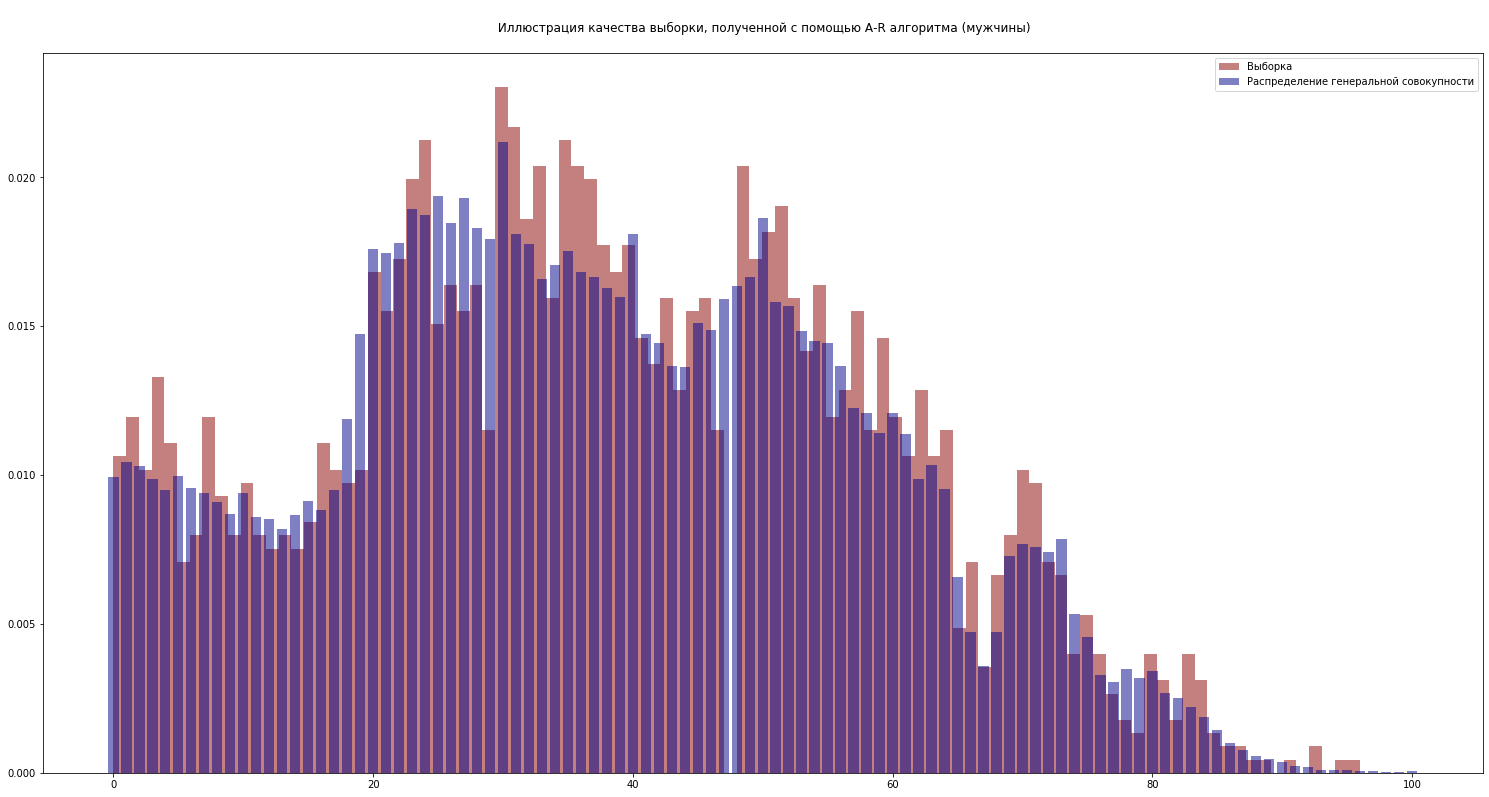

In [585]:
for i in range(len(VEC_m)):
    VEC_m[i] = int(VEC_m[i])
    
fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0, 0, 1, 1])

plt.hist(VEC_m,
         bins = 98,
         color = 'darkred',
         density = True,
         alpha = 0.5,
         label = 'Выборка');   



plt.bar(range(len(density_men)),
        density_men,
        color = 'darkblue',
        alpha = 0.5,
        label = 'Распределение генеральной совокупности');
plt.legend(loc = 'upper right')
ax.set_title('\n Иллюстрация качества выборки, полученной с помощью A-R алгоритма (мужчины)\n');
plt.savefig('maleAR')

In [586]:
'''
Повторяем аналогичную процедуру для женщин

В качестве N берем число женщин в имитации
'''

N = num_females
T = 1
VEC_f = np.zeros(N)
for i in tqdm(range(T)):
    v = sample(N,42,35,'female') #помни про параметры
    v.sort()
    VEC_f = VEC_f + v
    
VEC_f = VEC_f/T
VEC_f = list(VEC_f)


for i in range(VEC_f.count(0)//2):
    VEC_f[i] = random.randint(0,100)
    



100%|██████████| 1/1 [04:07<00:00, 247.33s/it]


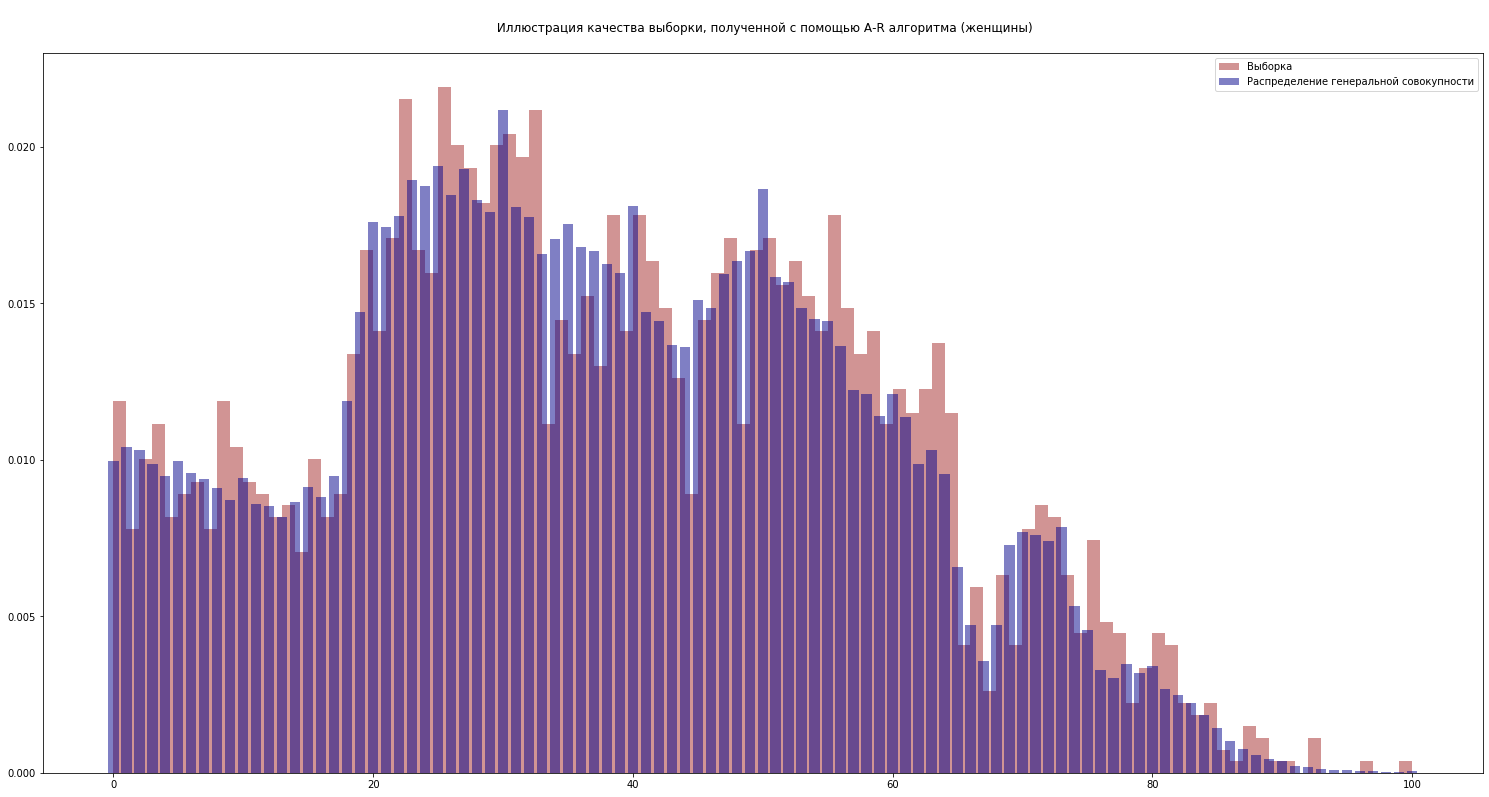

In [587]:
for i in range(len(VEC_f)):
    VEC_f[i] = int(VEC_f[i])

fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0, 0, 1, 1])

plt.hist(VEC_f,
         bins = 100,
         color = 'brown',
         density = True,
         alpha = 0.5,
         label = 'Выборка');   



plt.bar(range(len(density_women)),
        density_men,
        color = 'darkblue',
        alpha = 0.5,
        label = 'Распределение генеральной совокупности');
plt.legend(loc = 'upper right')
ax.set_title('\n Иллюстрация качества выборки, полученной с помощью A-R алгоритма (женщины)\n');
plt.savefig('womenAR.png')

### Осталось лишь распределить эти возраста между людьми соответствующего пола.

Поскольку мы предусмотрительно строили выборки размера, соответствующего числу мужчин и женщин в выборке, присваивание можно организовать напрямую.

In [588]:
for person in people_dictionary.keys():
    if people_dictionary[person]['Пол'] == 1:
        people_dictionary[person]['Возраст'] = VEC_m.pop(0)
        

In [589]:
for person in people_dictionary.keys():
    if people_dictionary[person]['Пол'] == 0:
        people_dictionary[person]['Возраст'] = VEC_f.pop(0)

In [590]:
print('Выведем, например, возраст нулевого человека: {}'.format(people_dictionary[0]['Возраст']))

Выведем, например, возраст нулевого человека: 30


Таким образом, мы получили население, половозрастная структура которого соответствует изначальному прототипу.

Переменная пола статична, переменная возраста увеличивается итерационно вплоть до поглощающего состояния.

In [591]:
'''Звуковой сигнал об отработке'''

import winsound
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

# Генерирование графа

Генерацию устроим следующим образом: соблюдая некоторый набор правил устроим случайный сэмплинг. Сэмплинг свой для каждого размера домохозяйства. Вопрос плотности открыт. Распределение домохозяйств соблюдаем. Построим переходную матрицу между типами домохзяйств.

In [592]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Для начала зададим начальный вектор клик - малых полных графов, в которых существуют все связи. Затем набросаем случайных связей между домохозйяствами. Эдакая модификация Small-World-graph.

In [593]:
'''
Данные: https://www.gks.ru/free_doc/new_site/perepis2010/croc/vol6pdf.html
'''

hh_dist_mo = np.array([736616,760777,642464,404735,140932,74483])

hh_dist_msc = np.array([1197839,1149095,1015265,634953,257772,161163])

hh_mo = np.sum(hh_dist_mo)
hh_msc = np.sum(hh_dist_msc)

w_mo = hh_mo/(hh_mo + hh_msc)
w_msc = hh_msc/(hh_mo + hh_msc)

msc = hh_dist_msc*w_msc/(w_msc + w_mo)
mo = hh_dist_mo*w_mo/(w_msc + w_mo)

hh_dist = (msc + mo)/(hh_mo + hh_msc)

hh_dist = hh_dist/sum(hh_dist)
hh_dist

cum = np.cumsum(hh_dist)

Определим сколько каких домохозяйств попало в нашу популяцию почти наверное.

In [594]:
import random

def random_hh_type():
    gen = random.uniform(0,1)
    
    if gen < cum[0]:
        return 1
    elif gen > cum[0] and gen < cum[1]:
        return 2
    elif gen > cum[1] and gen < cum[2]:
        return 3
    elif gen > cum[2] and gen < cum[3]:
        return 4
    elif gen > cum[3] and gen < cum[4]:
        return 5
    elif gen > cum[4] and gen < cum[5]:
        return 6

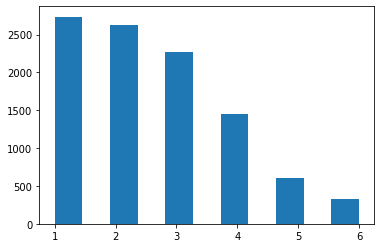

In [595]:
'''
Видим, что распределение соблюдено
'''

vec = []
for i in range(10000):
    vec.append(random_hh_type())
    
plt.hist(vec,bins = 11);



Теперь своздадим ячейки домохозяйств с помощью случайного сэмплинга, описанного выше. Т.е. количество домохозяйств каждого размера будет определено уже сейчас.

In [596]:
len(people_dictionary)

5000

In [597]:
random.seed(73) # выбрал, чтобы ровно 5000 распределилось, ближайшее к 69, возиться с ровной суммой в рамках симуляции долго и бессмысленно

upper_bound = 0
hh_id = 0
dictionary_of_hh = {}

while upper_bound < 5000:
    
    dictionary_of_hh[hh_id] = {}
    
    dictionary_of_hh[hh_id]['size'] = random_hh_type()
    
    upper_bound += dictionary_of_hh[hh_id]['size'] 

    
    hh_id += 1
    
    

In [598]:
summ = 0
for key in dictionary_of_hh.keys():
    summ += dictionary_of_hh[key]['size']
print(summ)

5000


Создадим лист из всех нераспределенных людей и заполним для начала домохозяйства, в которых проживает один человек. Также необходимо сформулировать ряд правил, которые будут блокировать большую часть обсурдных ситуаций при формировании домохозяйств.

In [599]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [600]:
for keys in dictionary_of_hh.keys():
    dictionary_of_hh[keys]['Members'] = []

#### Размер 1.

- одинокий мужчина

- одинокая женщина

Думаем про распределение по возрастным группам

Данные о распределении с Gks.

In [601]:
hh_1_age_dist = np.array([3681,10862,136140,174283,167371,181407,182310,341499])

hh_1 = hh_1_age_dist/sum(hh_1_age_dist)

In [602]:
age_group_bounds = pd.DataFrame()
age_group_bounds['down'] = pd.Series([0,15,18,25,35,45,55,65])
age_group_bounds['up'] = pd.Series([14,17,24,34,44,54,64,120])

In [603]:
def define_age(ind):
    return people_dictionary[ind]['Возраст']
       
def define_age_group(age):
    for i in range(len(age_group_bounds)):
        if age >= age_group_bounds['down'][i] and age <= age_group_bounds['up'][i]:
            return i
    

In [604]:
'''
Создадим вспомогательный датафрейм для random.choice
'''


helpful = pd.DataFrame()
helpful['id'] = pd.Series(list_of_people_ids)
helpful['age'] = helpful['id'].apply(lambda x: define_age(x))
helpful['age_group'] = helpful['age'].apply(lambda x: define_age_group(x))

def quantity_in_ag(age_group):
    return list(helpful['age_group']).count(age_group)

helpful['quantity_in_ag'] = helpful['age_group'].apply(lambda x: quantity_in_ag(x))

def prob(age_group):
    return hh_1[age_group]

helpful['prob'] = helpful['age_group'].apply(lambda x: prob(x))
helpful['uni_prob'] = helpful['prob']/helpful['quantity_in_ag']
helpful.head()

,id,age,age_group,quantity_in_ag,prob,uni_prob
0,0,30,3,896,0.145533,0.000162
1,1,45,5,785,0.151481,0.000193
2,2,9,0,696,0.003074,0.000004
3,3,68,7,511,0.285164,0.000558
4,4,87,7,511,0.285164,0.000558


In [605]:
random.choices(helpful['id'],weights = list(helpful['uni_prob']))

[4982]

In [606]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [607]:
for keys in dictionary_of_hh.keys():
    if dictionary_of_hh[keys]['size'] == 1 and len(dictionary_of_hh[keys]['Members']) == 0:
        
        candidate = random.choices(helpful['id'],weights = list(helpful['uni_prob']))[0]
        people_dictionary[candidate]['hh_id'] = keys
        dictionary_of_hh[keys]['Members'].append(candidate)
    

In [608]:
cnt = 0

for keys in people_dictionary.keys():
    if 'hh_id' in people_dictionary[keys].keys():
        cnt +=1
cnt

552

Итак, получили унитарные домохозяйства. Теперь с размерностью 2.

### Size 2.

Повторим идентичную процедуру для каждого размера, каждый раз создавая свой датасет, можно в целом даже перезаписывать, чтобы сохранять разницу в возрастных распределениях

In [609]:
hh_2_age_dist = np.array([112432,
34063,
201960,
356412,
301265,
381884,
394116,
515879])

hh_2 = hh_2_age_dist/sum(hh_2_age_dist)


In [610]:
age_group_bounds = pd.DataFrame()
age_group_bounds['down'] = pd.Series([0,15,18,25,35,45,55,65])
age_group_bounds['up'] = pd.Series([14,17,24,34,44,54,64,120])

In [611]:
def define_age(ind):
    return people_dictionary[ind]['Возраст']
       
def define_age_group(age):
    for i in range(len(age_group_bounds)):
        if age >= age_group_bounds['down'][i] and age <= age_group_bounds['up'][i]:
            return i
    

In [612]:
'''
Создадим вспомогательный датафрейм для random.choice
'''


helpful = pd.DataFrame()
helpful['id'] = pd.Series(list_of_people_ids)
helpful['age'] = helpful['id'].apply(lambda x: define_age(x))
helpful['age_group'] = helpful['age'].apply(lambda x: define_age_group(x))

def quantity_in_ag(age_group):
    return list(helpful['age_group']).count(age_group)

helpful['quantity_in_ag'] = helpful['age_group'].apply(lambda x: quantity_in_ag(x))

def prob(age_group):
    return hh_2[age_group]

helpful['prob'] = helpful['age_group'].apply(lambda x: prob(x))
helpful['uni_prob'] = helpful['prob']/helpful['quantity_in_ag']
helpful.head()

,id,age,age_group,quantity_in_ag,prob,uni_prob
0,0,30,3,896,0.155096,0.000173
1,1,45,5,785,0.166180,0.000212
2,2,9,0,696,0.048926,0.000070
3,3,68,7,511,0.224489,0.000439
4,4,87,7,511,0.224489,0.000439


In [613]:
random.choices(helpful['id'],weights = list(helpful['uni_prob']))

[3939]

In [614]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [615]:
for keys in dictionary_of_hh.keys():
    if dictionary_of_hh[keys]['size'] == 2 and len(dictionary_of_hh[keys]['Members']) == 0:
        cnt = 0
        while cnt<2:
            candidate = random.choices(helpful['id'],weights = list(helpful['uni_prob']))[0]
            if 'hh_id' not in people_dictionary[candidate]:
                people_dictionary[candidate]['hh_id'] = keys
                dictionary_of_hh[keys]['Members'].append(candidate)
                cnt +=1
            else:
                continue
    

In [616]:
cnt = 0

for keys in dictionary_of_hh.keys():
    if len(dictionary_of_hh[keys]['Members']) > 1:
        cnt +=1
cnt

563

### Size 3

In [617]:
hh_3_age_dist = np.array([358332,
75387,
336866,
558165,
494945,
541491,
361521,
318805])

hh_3 = hh_3_age_dist/sum(hh_3_age_dist)


In [618]:
age_group_bounds = pd.DataFrame()
age_group_bounds['down'] = pd.Series([0,15,18,25,35,45,55,65])
age_group_bounds['up'] = pd.Series([14,17,24,34,44,54,64,120])

In [619]:
def define_age(ind):
    return people_dictionary[ind]['Возраст']
       
def define_age_group(age):
    for i in range(len(age_group_bounds)):
        if age >= age_group_bounds['down'][i] and age <= age_group_bounds['up'][i]:
            return i
    

In [620]:
'''
Создадим вспомогательный датафрейм для random.choice
'''


helpful = pd.DataFrame()
helpful['id'] = pd.Series(list_of_people_ids)
helpful['age'] = helpful['id'].apply(lambda x: define_age(x))
helpful['age_group'] = helpful['age'].apply(lambda x: define_age_group(x))

def quantity_in_ag(age_group):
    return list(helpful['age_group']).count(age_group)

helpful['quantity_in_ag'] = helpful['age_group'].apply(lambda x: quantity_in_ag(x))

def prob(age_group):
    return hh_3[age_group]

helpful['prob'] = helpful['age_group'].apply(lambda x: prob(x))
helpful['uni_prob'] = helpful['prob']/helpful['quantity_in_ag']
helpful.head()

,id,age,age_group,quantity_in_ag,prob,uni_prob
0,0,30,3,896,0.183275,0.000205
1,1,45,5,785,0.177800,0.000226
2,2,9,0,696,0.117659,0.000169
3,3,68,7,511,0.104680,0.000205
4,4,87,7,511,0.104680,0.000205


In [621]:
random.choices(helpful['id'],weights = list(helpful['uni_prob']))

[1617]

In [622]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [623]:
for keys in dictionary_of_hh.keys():
    if dictionary_of_hh[keys]['size'] == 3 and len(dictionary_of_hh[keys]['Members']) == 0:
        cnt = 0
        while cnt<3:
            candidate = random.choices(helpful['id'],weights = list(helpful['uni_prob']))[0]
            if 'hh_id' not in people_dictionary[candidate]:
                people_dictionary[candidate]['hh_id'] = keys
                dictionary_of_hh[keys]['Members'].append(candidate)
                cnt +=1
            else:
                continue
    

In [624]:
cnt = 0

for keys in dictionary_of_hh.keys():
    if len(dictionary_of_hh[keys]['Members']) == 3:
        cnt +=1
cnt

433

### Size 4

In [625]:
hh_4_age_dist = np.array([442011,
83579,
295152,
445478,
404316,
399842,
252920,
216230])

hh_4 = hh_4_age_dist/sum(hh_4_age_dist)


In [626]:
age_group_bounds = pd.DataFrame()
age_group_bounds['down'] = pd.Series([0,15,18,25,35,45,55,65])
age_group_bounds['up'] = pd.Series([14,17,24,34,44,54,64,120])

In [627]:
def define_age(ind):
    return people_dictionary[ind]['Возраст']
       
def define_age_group(age):
    for i in range(len(age_group_bounds)):
        if age >= age_group_bounds['down'][i] and age <= age_group_bounds['up'][i]:
            return i
    

In [628]:
'''
Создадим вспомогательный датафрейм для random.choice
'''


helpful = pd.DataFrame()
helpful['id'] = pd.Series(list_of_people_ids)
helpful['age'] = helpful['id'].apply(lambda x: define_age(x))
helpful['age_group'] = helpful['age'].apply(lambda x: define_age_group(x))

def quantity_in_ag(age_group):
    return list(helpful['age_group']).count(age_group)

helpful['quantity_in_ag'] = helpful['age_group'].apply(lambda x: quantity_in_ag(x))

def prob(age_group):
    return hh_4[age_group]

helpful['prob'] = helpful['age_group'].apply(lambda x: prob(x))
helpful['uni_prob'] = helpful['prob']/helpful['quantity_in_ag']
helpful.head()

,id,age,age_group,quantity_in_ag,prob,uni_prob
0,0,30,3,896,0.175418,0.000196
1,1,45,5,785,0.157447,0.000201
2,2,9,0,696,0.174052,0.000250
3,3,68,7,511,0.085146,0.000167
4,4,87,7,511,0.085146,0.000167


In [629]:
random.choices(helpful['id'],weights = list(helpful['uni_prob']))

[2195]

In [630]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [631]:
for keys in dictionary_of_hh.keys():
    if dictionary_of_hh[keys]['size'] == 4 and len(dictionary_of_hh[keys]['Members']) == 0:
        cnt = 0
        while cnt<4:
            candidate = random.choices(helpful['id'],weights = list(helpful['uni_prob']))[0]
            if 'hh_id' not in people_dictionary[candidate]:
                people_dictionary[candidate]['hh_id'] = keys
                dictionary_of_hh[keys]['Members'].append(candidate)
                cnt +=1
            else:
                continue
    

In [632]:
cnt = 0

for keys in dictionary_of_hh.keys():
    if len(dictionary_of_hh[keys]['Members']) == 4:
        cnt +=1
cnt

285

# Size 5

In [633]:
hh_5_age_dist = np.array([467367,
67980,
249236,
468202,
358952,
322412,
250161,
213446])

hh_5 = hh_5_age_dist/sum(hh_5_age_dist)


In [634]:
age_group_bounds = pd.DataFrame()
age_group_bounds['down'] = pd.Series([0,15,18,25,35,45,55,65])
age_group_bounds['up'] = pd.Series([14,17,24,34,44,54,64,120])

In [635]:
def define_age(ind):
    return people_dictionary[ind]['Возраст']
       
def define_age_group(age):
    for i in range(len(age_group_bounds)):
        if age >= age_group_bounds['down'][i] and age <= age_group_bounds['up'][i]:
            return i
    

In [636]:
'''
Создадим вспомогательный датафрейм для random.choice
'''


helpful = pd.DataFrame()
helpful['id'] = pd.Series(list_of_people_ids)
helpful['age'] = helpful['id'].apply(lambda x: define_age(x))
helpful['age_group'] = helpful['age'].apply(lambda x: define_age_group(x))

def quantity_in_ag(age_group):
    return list(helpful['age_group']).count(age_group)

helpful['quantity_in_ag'] = helpful['age_group'].apply(lambda x: quantity_in_ag(x))

def prob(age_group):
    return hh_5[age_group]

helpful['prob'] = helpful['age_group'].apply(lambda x: prob(x))
helpful['uni_prob'] = helpful['prob']/helpful['quantity_in_ag']
helpful.head()

,id,age,age_group,quantity_in_ag,prob,uni_prob
0,0,30,3,896,0.195267,0.000218
1,1,45,5,785,0.134464,0.000171
2,2,9,0,696,0.194918,0.000280
3,3,68,7,511,0.089019,0.000174
4,4,87,7,511,0.089019,0.000174


In [637]:
random.choices(helpful['id'],weights = list(helpful['uni_prob']))

[2485]

In [638]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [639]:
for keys in dictionary_of_hh.keys():
    if dictionary_of_hh[keys]['size'] == 5 and len(dictionary_of_hh[keys]['Members']) == 0:
        cnt = 0
        while cnt<5:
            candidate = random.choices(helpful['id'],weights = list(helpful['uni_prob']))[0]
            if 'hh_id' not in people_dictionary[candidate]:
                people_dictionary[candidate]['hh_id'] = keys
                dictionary_of_hh[keys]['Members'].append(candidate)
                cnt +=1
            else:
                continue
    

In [640]:
cnt = 0

for keys in dictionary_of_hh.keys():
    if len(dictionary_of_hh[keys]['Members']) == 5:
        cnt +=1
cnt

98

In [641]:
cnt = 0
for keys in people_dictionary.keys():
    if 'hh_id' not in people_dictionary[keys].keys():
        cnt += 1
print(cnt)

393


### Size 6+

In [642]:
hh_6_age_dist = np.array([467367,
67980,
249236,
468202,
358952,
322412,
250161,
213446])

hh_6 = hh_6_age_dist/sum(hh_5_age_dist)


In [643]:
age_group_bounds = pd.DataFrame()
age_group_bounds['down'] = pd.Series([0,15,18,25,35,45,55,65])
age_group_bounds['up'] = pd.Series([14,17,24,34,44,54,64,120])

In [644]:
def define_age(ind):
    return people_dictionary[ind]['Возраст']
       
def define_age_group(age):
    for i in range(len(age_group_bounds)):
        if age >= age_group_bounds['down'][i] and age <= age_group_bounds['up'][i]:
            return i
    

In [645]:
'''
Создадим вспомогательный датафрейм для random.choice
'''


helpful = pd.DataFrame()
helpful['id'] = pd.Series(list_of_people_ids)
helpful['age'] = helpful['id'].apply(lambda x: define_age(x))
helpful['age_group'] = helpful['age'].apply(lambda x: define_age_group(x))

def quantity_in_ag(age_group):
    return list(helpful['age_group']).count(age_group)

helpful['quantity_in_ag'] = helpful['age_group'].apply(lambda x: quantity_in_ag(x))

def prob(age_group):
    return hh_6[age_group]

helpful['prob'] = helpful['age_group'].apply(lambda x: prob(x))
helpful['uni_prob'] = helpful['prob']/helpful['quantity_in_ag']
helpful.head()

,id,age,age_group,quantity_in_ag,prob,uni_prob
0,0,30,3,896,0.195267,0.000218
1,1,45,5,785,0.134464,0.000171
2,2,9,0,696,0.194918,0.000280
3,3,68,7,511,0.089019,0.000174
4,4,87,7,511,0.089019,0.000174


In [646]:
random.choices(helpful['id'],weights = list(helpful['uni_prob']))

[2720]

In [647]:
list_of_people_ids = []

for key in people_dictionary.keys():
    list_of_people_ids.append(key)

In [648]:
for keys in dictionary_of_hh.keys():
    if dictionary_of_hh[keys]['size'] == 6 and len(dictionary_of_hh[keys]['Members']) == 0:
        cnt = 0
        while cnt<6:
            candidate = random.choices(helpful['id'],weights = list(helpful['uni_prob']))[0]
            if 'hh_id' not in people_dictionary[candidate]:
                people_dictionary[candidate]['hh_id'] = keys
                dictionary_of_hh[keys]['Members'].append(candidate)
                cnt +=1
            else:
                continue
    

In [649]:
cnt = 0

for keys in dictionary_of_hh.keys():
    if len(dictionary_of_hh[keys]['Members']) == 6:
        cnt +=1
cnt

60

In [650]:
for keys in list(people_dictionary.keys()):
    if 'hh_id' not in people_dictionary[keys].keys():
        del people_dictionary[keys]

### Закончили распределять. Теперь необходимо на основании структуры, заданной словарем people_dictionary сконструировать small-world-graph с полносвязными кликами.

In [651]:
'''
Уже трясутся руки, как долго мы к этому шли, но все-таки, некоторые дополнительные приготовления.
'''

'\nУже трясутся руки, как долго мы к этому шли, но все-таки, некоторые дополнительные приготовления.\n'

In [652]:
for people in people_dictionary.keys():
    mmbrs = dictionary_of_hh[people_dictionary[people]['hh_id']]['Members']
    #mmbrs.remove(people)
    people_dictionary[people]['hh_members'] = mmbrs

'''
Создаем основные подмассивы ребер для создания плотных клик
'''

'\nСоздаем основные подмассивы ребер для создания плотных клик\n'

In [653]:
clique_edges = []

for keys in people_dictionary.keys():
    for elems in people_dictionary[keys]['hh_members']:
        clique_edges.append((keys,elems))

In [654]:
'''
Устраняем петли
'''

for elems in clique_edges:
    if elems[0] == elems[1]:
        clique_edges.remove(elems)
len(clique_edges)

11631

In [655]:
random_uniform_edges = []

for i in range(1500):
    a = random.choice(list(people_dictionary))
    b = random.choice(list(people_dictionary))
    random_uniform_edges.append((a,b))

In [656]:
len(random_uniform_edges)

1500

In [657]:
# по идее вот тут начало итерации на графе, мы создаем его заново из текущей версии всех словарей и ребер

In [658]:
G = nx.Graph()

G.add_nodes_from(people_dictionary)
G.add_edges_from(clique_edges)
print(len(G.edges()))
G.add_edges_from(random_uniform_edges)
print(len(G.edges()))


#Отрисовка
'''

plt.figure(figsize = (25,25))
nx.draw_kamada_kawai(G,
        node_size = 12,
        edge_color = 'black',
        node_color = 'darkred',
        edge_width = 12)
'''

6179
7679


"\n\nplt.figure(figsize = (25,25))\nnx.draw_kamada_kawai(G,\n        node_size = 12,\n        edge_color = 'black',\n        node_color = 'darkred',\n        edge_width = 12)\n"

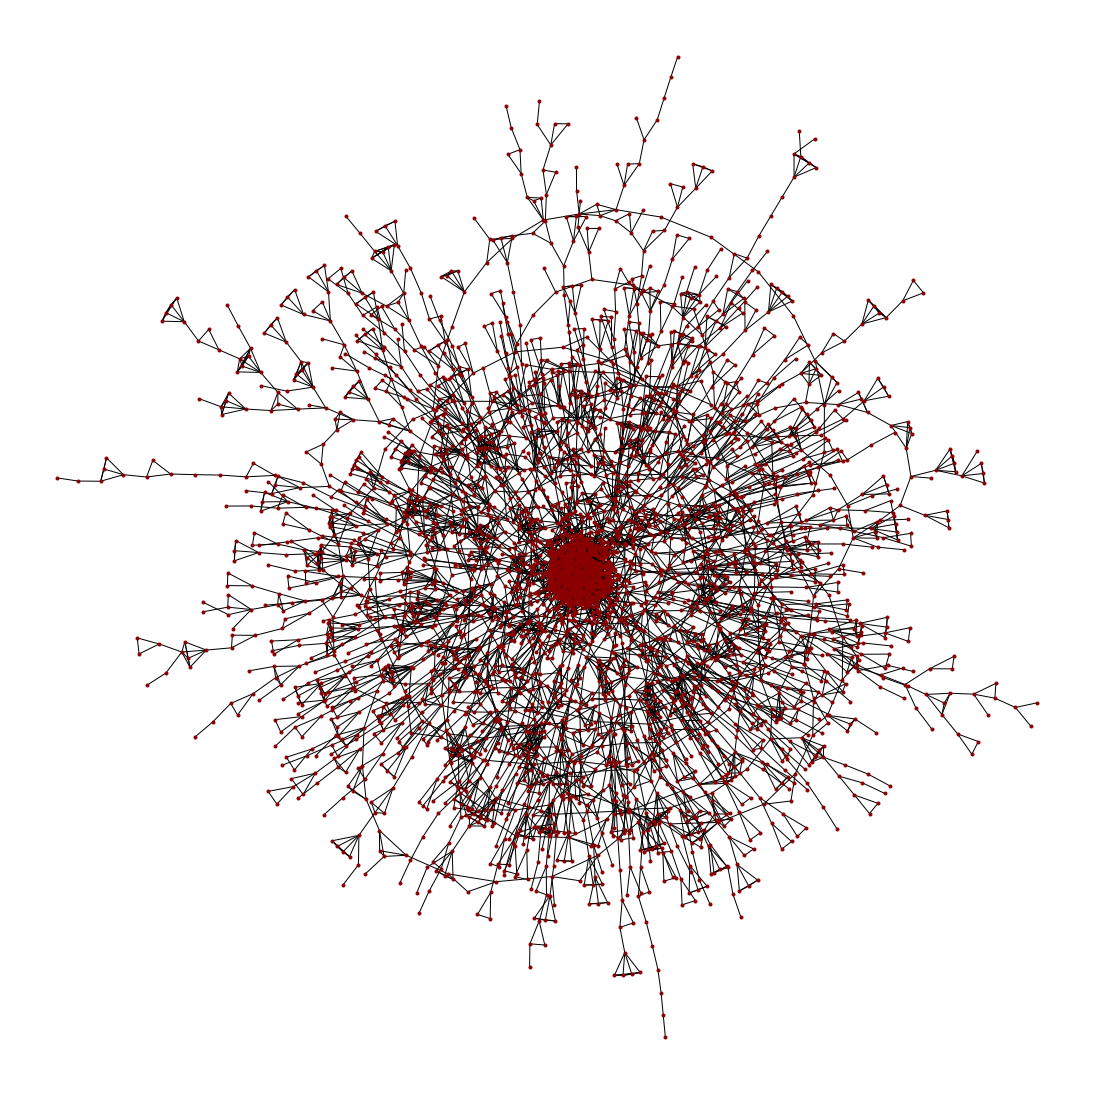

In [659]:
plt.figure(figsize = (15,15))
nx.draw_kamada_kawai(G,node_size = 9,node_color = 'darkred')

### Что дальше?

- оболочка графа построена (done)

- необходимо достать из собранного словаря атрибуты вершин (done)

- подумать про то, насколько структура графа согласуется со здравым смыслом (done)

- реализовать модель распространения паттернов (Ant_model)

- реализовать функцию респлита с информационной поддержкой в терминах базового словаря (отделение домохозяйства)

- реализовать минимум 10 шагов иммитации (hh_id) будем добавлять по мере рождения, ограничим сплиттер по возрасту

- подумать про то, какая доля будет отселяться не в одиночку (брачность и прочее)


In [660]:
# Атрибуты будем добавлять через столь удобно реализованную в питоне методику подсловарей

age_dict = {}
for keys in people_dictionary.keys():
    age_dict[keys] = people_dictionary[keys]['Возраст']
    
gender_dict = {}
for keys in people_dictionary.keys():
    gender_dict[keys] = people_dictionary[keys]['Пол']
    
hh_id_dict = {}
for keys in people_dictionary.keys():
    hh_id_dict[keys] = people_dictionary[keys]['hh_id']

dead_dict = {}
for keys in people_dictionary.keys():
    dead_dict[keys] = 0

In [661]:
nx.set_node_attributes(G, age_dict, 'Возраст')
nx.set_node_attributes(G, gender_dict, 'Пол')
nx.set_node_attributes(G, hh_id_dict, 'Household')
nx.set_node_attributes(G, dead_dict, 'dead')

### Ant Model

Идея этой вероятностной модели состоит в следующем:

- у всех игроков популяции изначально есть некоторое мнение относительно некоторого вопроса (например, о том, стоит ли отделяться от действующего домохозяйства и образовывать новое нуклеарное). У уже нуклеарных 1, у ненуклеарных 0.

- на каждой итерации игрок принимает 2 решения:

    * 1 монета: с вероятностью p игрок принимает второе решение, с вероятностью 1-p прислушивается к среднему мнению соседей
    * 2 монета: если на первой реализовался первый исход, с вероятностью q игрок производит действие, с вероятностью 1-q остается в текущем статусе

In [662]:
def match_opinion(person):
    matcher = dictionary_of_hh[people_dictionary[keys]['hh_id']]['size']
    if matcher == 1:
        return 1
    else:
        return 0
        


In [663]:
dictionary_of_opinions = {}
for keys in people_dictionary.keys():
    dictionary_of_opinions[keys] = match_opinion(keys)

In [664]:
nx.set_node_attributes(G,dictionary_of_opinions,'opinion')

Возможности и желания по образованию нуклеарного домохозяйства различны в разных возрастах. Некоторую базовую вероятность $p$ мы поставим в зависимость от возраста агента:

некоторую общую базовую вероятность мы инкриментируем в зависимости от возраста индивида, зависимость возьмем из текущей возрастной структуры нуклеарных домохозяйств.

Здесь снова подгрузим наши выходы из других моделей, чтобы переписать заново итерацию. Во время итерации будут происходить следующие вещи:

- смерти-рождения

- очистка (dead_cleaner)

- сплиты с передачей информации

Пойдем по пунктам, учитывая опыт уже написанных функций для словарей

### Смерти в симуляции

- у каждой ноды в атрибуте есть вероятность умереть в течение года, которая обновляется на каждом шагу, ступень обновления - в глобальной переменной TIME, стартующей с 2011 года

- реализуем случайную величину, либо человек умирает, либо стареет

- если он умирает, он получает статус dead = 1 в атрибутах


- если он стареет, связи остаются, возраст как атрибут увеличивается на 1


### Очистка

Пробегаемся перебором по всем вершинам и если у ноды статус dead = 1, то убираем ее из списка нод, удаляем все ребра с нею связанные

### Рождения

У каждой женщины в зависимости от возраста есть вероятность родить ребенка, если такое случайное событие реализуется, то

- ребенок получает id и добавляется в список вершин

- появляются все связи с членами домохозяйства, в котором состояла мать

- пол определяется случайно, барьерным методом

- все дальнейшие правила на ребенка распространяются как и на остальных агентов

Порядок реализации смерти-рождения выбирается барьерно, 0.5.

### Сплиты

Для каждого индивида реализуется алгорит потенциального сплиттинга, согласно ant-модели

Если он отделяется, то он либо присоединяется к случайному домохозяйству, образуя там все связи и разрывая все старые, кроме какой-то одной

Либо он образует нуклеарное домохозяйство и далее функционирует по обычным правилам.




In [665]:
TIME = 2011

# Смерти

In [666]:
# считываем файл с вероятностями смерти в конкретных возрастах

probs_death_m = pd.read_csv('results_men.csv')
probs_death_w = pd.read_csv('results_women.csv')

del probs_death_m['Unnamed: 0']
del probs_death_w['Unnamed: 0']

In [667]:
# создадим словарь с ключами по людям и со значениями по вероятности смерти в зависимости от возраста

def create_death_dict(TIME):

    dict_death = {}

    for keys in people_dictionary.keys():
        gender = people_dictionary[keys]['Пол']
        age = people_dictionary[keys]['Возраст']

        if gender == 1:
            for i in range(len(probs_death_m)):
                if age >= probs_death_m['start'].iloc[i] and age <= probs_death_m['finish'].iloc[i]:
                    age_group = i
                else:
                    continue
            dict_death[keys] = probs_death_m[str(TIME)].iloc[age_group]
        else:
            for i in range(len(probs_death_m)):
                if age >= probs_death_m['start'].iloc[i] and age <= probs_death_w['finish'].iloc[i]:
                    age_group = i
                else:
                    continue
            dict_death[keys] = probs_death_w[str(TIME)].iloc[age_group]

        
    return dict_death

In [668]:
# применяем, чтобы дальше работало

death_dict = create_death_dict(2011)

nx.set_node_attributes(G,death_dict,'death_prob')

In [669]:
def person_death_iteration(G_node):
    # в аргументах инстанс ноды графа
    gen = random.uniform(0,1)
    if gen < G.nodes[G_node]['death_prob']:
        G.nodes[G_node]['dead'] = 1
    else:
        G.nodes[G_node]['dead'] = 0
    

### Теперь функция очистки графа

Сюда же мы поместим функцию старения, применяемую уже после очистки

In [670]:
def the_cleaner(G):
    for node in list(G.nodes):
        if G.nodes[node]['dead'] == 1:
            G.remove_node(node)
    print('Graph is clean!')  
    
    for nodes in G.nodes():
        G.nodes[nodes]['Возраст'] += 1
# Удобно, автоматически удаляются и все смежные с ней ребра, боже храни стенфордских авторов пакета

### Объединяем функции смерти и очистки в один итерационный шаг (пойдет в итоговые итерации)

In [671]:
def death_iteration(G):
    for node in G.nodes():
        person_death_iteration(node)
    the_cleaner(G)
    print('One death iteration finished!') 

### Рождения

Теперь считаем файл с информацией о рождаемости и каждой женщине или девушке присвоим вероятностный порог рождения ребенка. Реализуем интеграцию ребенка в сеть.

In [672]:
probs_birth = pd.read_csv('birth_results.csv')
del probs_birth['Unnamed: 0']

In [673]:
def create_birth_dict(TIME):
    
    
    dict_birth = {}

    for keys in people_dictionary.keys():
        gender = people_dictionary[keys]['Пол']

        if gender == 1:
            dict_birth[keys] = 0
            
        else:
            age = people_dictionary[keys]['Возраст']
            if age < 15:
                dict_birth[keys] = 0
            elif age > 55:
                dict_birth[keys] = 0
            else:
                dict_birth[keys] = probs_birth[str(TIME)].iloc[age - 15]
    return dict_birth

In [674]:
# применяем, чтобы дальше работало

birth_dict = create_birth_dict(TIME)

nx.set_node_attributes(G,birth_dict,'birth_prob')

Теперь реализуем процесс рождения (если бы была миграция, было бы в целом очень похоже)

In [675]:
def give_birth(person):
    gen = random.uniform(0,1)
    tres = G.nodes[person]['birth_prob']
    if gen < tres:
        current_max_id = max(G.nodes())
        new_id = current_max_id + 1
        G.add_node(new_id)
        gender_gen = random.randint(0,1)
        
        # определяем пол
        if gender_gen < 0.461:
            G.nodes[new_id]['Пол'] = 1
        else:
            G.nodes[new_id]['Пол'] = 0
            
        G.nodes[new_id]['Возраст'] = 0
        G.nodes[new_id]['Household'] = int(G.nodes[person]['Household']) # подвязки к одному объекту не происходит из-за инта, тонкий момент
        G.nodes[new_id]['opinion'] = 0
        G.nodes[new_id]['dead'] = 0
        G.nodes[new_id]['birth_prob'] = 0

        if G.nodes[new_id]['Пол'] == 1:
            G.nodes[new_id]['death_prob'] = probs_death_m[str(TIME)].iloc[0]
        else:
            G.nodes[new_id]['death_prob'] = probs_death_w[str(TIME)].iloc[0]
            G.nodes[new_id]['born'] = True

            # c аттрибутами разобрались, теперь надо добавить ребра
            ## пополняем клику

            new_edges = []
            for person in dictionary_of_hh[G.nodes[new_id]['Household']]['Members']:
                new_edges.append((new_id,person))
            G.add_edges_from(new_edges)
            dictionary_of_hh[G.nodes[new_id]['Household']]['Members'].append(new_id)
    else:
        pass
            # print('Birth done')
    

In [676]:
# нивелирование ошибок перебора
def smoother():
    for p in list(G.nodes()):
        if 'birth_prob' not  in G.nodes[p].keys():
            G.remove_node(p)

In [677]:
def iteration_births(G):
    for people in list(G.nodes()):
            give_birth(people)
    smoother()   
    print('Birth iteration finished!')

In [678]:
### Тестируем, что у всех нодов, в том числе снова созданных, все в порядке с ключами

vec = []
for nodes in G.nodes():
    for key in list(G.nodes[nodes].keys()):
        vec.append(key)


a = True
for nodes in G.nodes():
    if list(G.nodes[nodes].keys()) == vec:
        a = True
    else:
        pass
print('Все в порядке?' + ' '+ str(a))

Все в порядке? True


In [679]:
def generate_additional_links_due_to_loss():
    
    vec = []
    
    for i in range(100):
        a = random.choices(list(G.nodes))[0]
        b = random.choices(list(G.nodes))[0]
        vec.append((a,b))
        
    G.add_edges_from(vec)
    

In [680]:
def household_cleaner():
    for keys in list(dictionary_of_hh.keys()):
        if len(dictionary_of_hh[keys]['Members']) == 0:
            del dictionary_of_hh[keys]
            
    for keys in list(dictionary_of_hh.keys()):
        dictionary_of_hh[keys]['size'] = len(dictionary_of_hh[keys]['Members'])

### Сплиттер из Ант-Модели

Смоделируем процесс принятия решения об отселении для различных возрастов, параллельно наложив несколько ограничений. Это будет объяснять почему некоторые добровольных нуклеарных домохозяйств может быть все больше.

In [681]:
# подбор этих параметров - отдельный разговор. Поставим в некоторую зависимость от возраста, которая покажется разумной исходя из динамики 2002-2010. Пока для теста просто фикс.

def compute_p1():
    p1 = 0.01
    return p1

def compute_p2():
    p2 = 0.02
    return p2

def compute_p3():
    p3 = 0.5
    return p3

In [682]:
p1 =compute_p1()
p2 = compute_p2()
p3 = compute_p3()

In [683]:


def splitter(person):
    
    solution_1 = random.uniform(0,1)
    solution_2 = random.uniform(0,1)
    solution_3 = random.uniform(0,1)
    
    for people in list(G.nodes()):
        if 'opinion' not in G.nodes()[people].keys():
            G.remove_node(people)
    
    if solution_1 < p1:
        
        neigh = list(G.neighbors(person))
        list_of_opinions = []
        
        for people in neigh:
            list_of_opinions.append(G.nodes()[people]['opinion'])
            
        self_opinion = np.mean(list_of_opinions)
            
        if self_opinion < 0.5:
            pass
            #print(0)
            
        else:
            if solution_3 < p3:
                new_nei = random.choices(list(G.nodes()))[0] # выбираем случайного человека и присоединяемся к его домохозяйству, наиболее вероятно это будет кто-то, кто жил один
                
                new_neibrs = []
                for p in dictionary_of_hh[G.nodes[new_nei]['Household']]['Members']:
                    new_neibrs.append(p)
                for i in range(3):
                    new_neibrs.append(random.choice(list(G.nodes())))   
                pairs = []
                for i in range(len(new_neibrs)):
                    pairs.append((person,new_neibrs[i]))
                G.add_edges_from(pairs)
                G.nodes[person]['opinion'] = 0
                #print(1)
                
            else:
                mx = max(dictionary_of_hh.keys())
                
                try:
                    dictionary_of_hh[G.nodes()[person]['Household']]['Members'].remove(person)
                except:
                    pass
                
                G.nodes()[person]['Household'] = mx + 1
                G.nodes()[person]['opinion'] = 1
                dictionary_of_hh[mx + 1] = {}
                dictionary_of_hh[mx+1]['Members'] = []
                dictionary_of_hh[mx+1]['Members'].append(person)
                dictionary_of_hh[mx+1]['size'] = 1
                #print(2)
                        
        
    elif solution_1 >= p1:
        
        if solution_2 < p2: # отделяемся, но уже в качестве самостоятельного решения. Снова же, либо присоединяемся к кому-то, либо уходим в нуклеары
            if solution_3 < p3:
                    new_nei = random.choices(list(G.nodes()))[0] # выбираем случайного человека и присоединяемся к его домохозяйству, наиболее вероятно это будет кто-то, кто жил один
                    
                    new_neibrs = []
                    for people in  dictionary_of_hh[G.nodes[new_nei]['Household']]['Members']:
                        new_neibrs.append(people)
                    for i in range(3):
                        new_neibrs.append(random.choice(list(G.nodes())))   
                    pairs = []
                    for i in range(len(new_neibrs)):
                        pairs.append((person,new_neibrs[i]))
                    G.add_edges_from(pairs)
                    G.nodes[person]['opinion'] = 0
                    #print(3)
                    
            else:
                mx = max(dictionary_of_hh.keys())
                
                try:
                    
                    dictionary_of_hh[G.nodes()[person]['Household']]['Members'].remove(person)
                except:
                    pass
                
                G.nodes()[person]['Household'] = mx + 1
                G.nodes()[person]['opinion'] = 1
                dictionary_of_hh[mx + 1] = {}
                dictionary_of_hh[mx+1]['Members'] = []
                dictionary_of_hh[mx+1]['Members'].append(person)
                dictionary_of_hh[mx+1]['size'] = 1
                #print(4)
        else:
            pass
            #print(5)
    
    

In [684]:
# диагностический тест изменений

def diagnose_hh():
    vec = []
    
    ans = []
    
    for keys in dictionary_of_hh.keys():
        vec.append(dictionary_of_hh[keys]['size'])

    for vals in set(vec):
        ans.append(vec.count(vals))  
        print(vals)
        
    return ans

In [685]:
household_cleaner()

In [686]:
# общая функция сплита
def all_splitter():
    for people in list(G.nodes()):
        splitter(people)
    

### Итерации на графе

In [687]:
TIME = 2011

In [688]:
def ITERATION(G,TIME):

    order_gen = random.uniform(0,1)

    if order_gen < 0.5:

        iteration_births(G)
        death_iteration(G)

    else:

        death_iteration(G)
        iteration_births(G)
        
    generate_additional_links_due_to_loss()  # корректировка дисбаланса выбытия плотности в связи со стертыми случайными связями (примерно одна пятая от итерационных потерь).
    
    all_splitter()
    
    household_cleaner() # Убираем домохозяйства, в которых осталось 0 членов, исправляем размеры домохозяйств на новые
       
    TIME += 1
        
    return G
    

In [693]:
history_vec = []

In [694]:
### Можно прокликать несколько раз, несколько раз и проитерируется
print(diagnose_hh())
ITERATION(G,TIME)
history_vec.append(G)
print(diagnose_hh())

1
2
3
4
5
6
7
[642, 554, 429, 282, 98, 58, 4]
Graph is clean!
One death iteration finished!
Birth iteration finished!
1
2
3
4
5
6
7
[697, 538, 444, 268, 101, 58, 6]


In [40]:
# оставлю в выводах отработку на глубоких итерациях

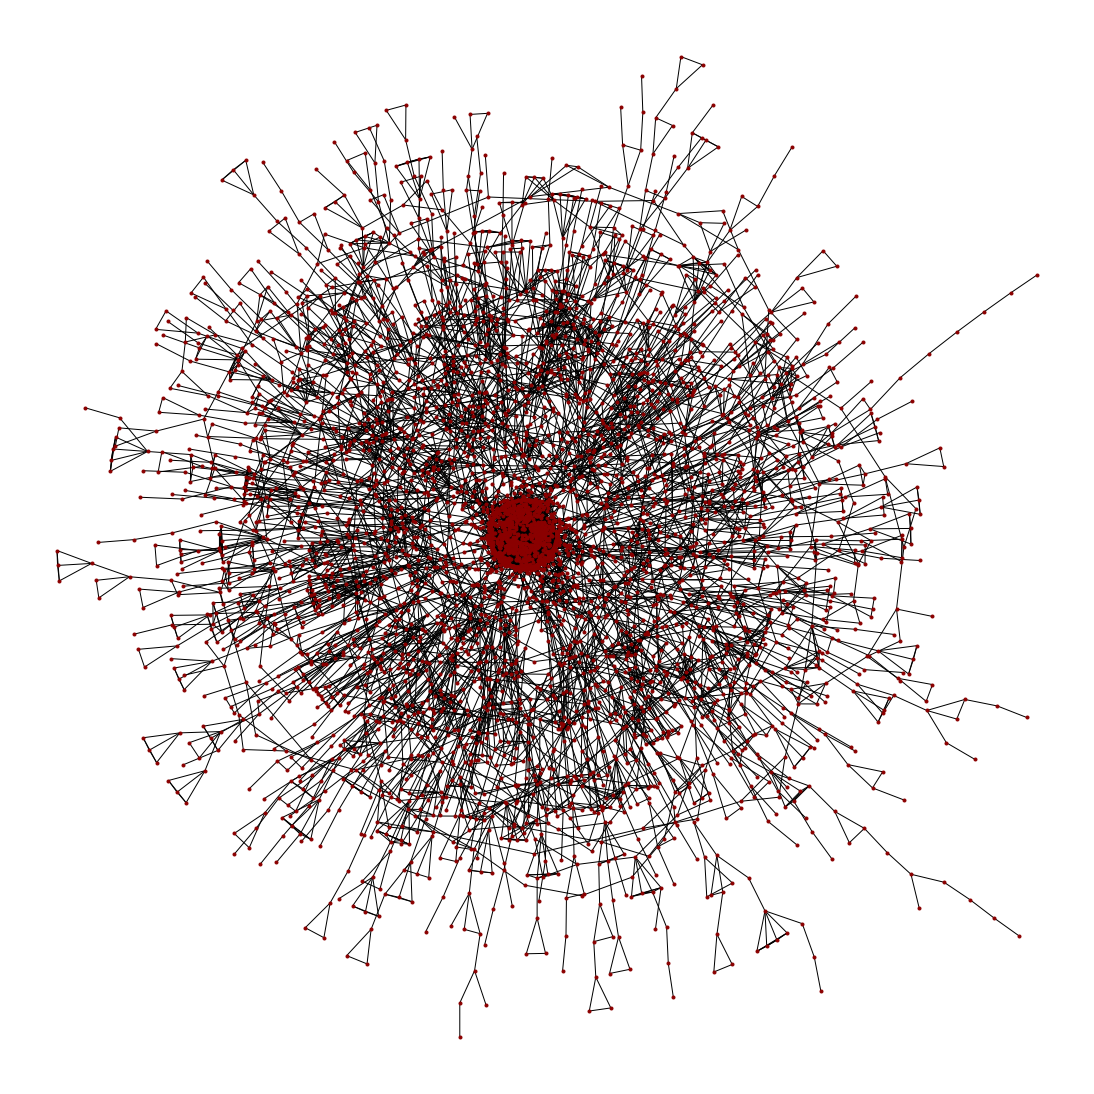

In [690]:
plt.figure(figsize = (15,15))
nx.draw_kamada_kawai(G,node_size = 9,node_color = 'darkred')

In [691]:
import winsound
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

In [31]:
# Отрисовка изменения в векторе домохозяйств
import matplotlib.pyplot as plt
import numpy as np
A= np.array([642, 554, 429, 282, 98, 58]) * np.array([1,2,3,4,5,6])
B = np.array([687, 518, 411, 248, 87, 54]) * np.array([1,2,3,4,5,6])

# Наслеление должно было уменьшиться

A.sum() > B.sum() 

True

In [41]:
# Cредние изменения по результатам 100 итераций (начинали всегда с одного места)'

mean_vec = pd.read_csv('results_iterations_100.csv')
mean_vec = mean_vec[0].iloc[0]

' Cредние изменения по результатам 100 итераций (начинали всегда с одного места)'

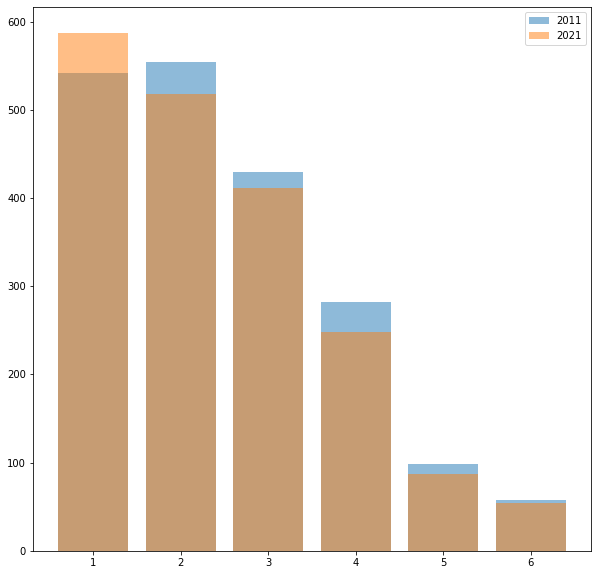

In [46]:
plt.figure(figsize = (10,10))
plt.bar([1,2,3,4,5,6],[542, 554, 429, 282, 98, 58], alpha = 0.5, label = '2011');
plt.bar([1,2,3,4,5,6], mean_vec, alpha = 0.5, label = '2021');
plt.legend()